## Topographic residual correction - step function
+ Figure S5 - The necessity of introducing step function in topographic residual correction in the presence of displacement jump

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy import linalg
from mintpy.objects import timeseries
from mintpy.simulation.plot import *
from mintpy.utils import ptime, readfile, utils as ut, plot as pp


work_dir = os.path.expanduser('~/Documents/Paper/2019_MintPy/Notebook/topoResid_step')
os.chdir(work_dir)
print('Go to directory:', work_dir)

unit_fac = 100.  # display in cm for data in unit of m

Go to directory: /Users/yunjunz/development/python/Yunjun_et_al-2019/topoResid_step


open timeseries file: timeseries_ECMWF_ramp.h5
displacement jump at 20160301
add topographic residual phase with DEM error of 50 m
estimated deltaZ: -14.087582694355067
estimated deltaZ: 30.055616614410983
save figure to file /Users/yunjunz/development/python/Yunjun_et_al-2019/topoResid_step/step4demErr_SenDsim.png


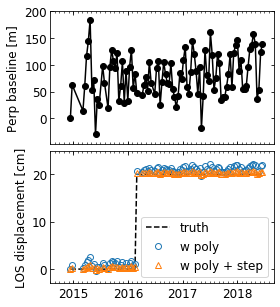

In [2]:
## Fig. S5a-b - Simulation with Sentinel-1

# prepare for simulations
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/mintpy')
ts_file = os.path.join(proj_dir, 'timeseries_ECMWF_ramp.h5')
# aux info
ts_obj = timeseries(ts_file)
ts_obj.open()
tbase = np.array(ts_obj.tbase, np.float32) / 365.25
pbase = ts_obj.pbase
tbase -= tbase[0]
pbase -= pbase[0]
dates = np.array(ts_obj.times)
# geometry
incAngle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
rangeDist = ut.range_distance(ts_obj.metadata, dimension=0, print_msg=False)
A_geom = pbase.reshape((-1,1)) / (rangeDist * np.sin(incAngle * np.pi / 180.))

# simulate time-series
ts_sim = np.zeros((ts_obj.numDate, 1), dtype=np.float32)
ts_sim[30:] = 0.20   # 10 cm displacement jump
print('displacement jump at', ts_obj.dateList[30])

# add topo resid phase
deltaZ = 50     # m, DEM error
ts = ts_sim + np.dot(A_geom, deltaZ)
print('add topographic residual phase with DEM error of {} m'.format(deltaZ))

def design_matrix(polyOrder=2, stepFuncDate=[]):
    # poly - 2
    polyOrder = 2
    A_def = np.ones((ts_obj.numDate, 1), np.float32)
    for i in range(polyOrder):
        Ai = np.array(tbase**(i+1) / gamma(i+2), np.float32).reshape(-1, 1)
        A_def = np.hstack((A_def, Ai))
    # step functions
    if stepFuncDate:
        t_steps = ptime.yyyymmdd2years(stepFuncDate)
        t = np.array(ptime.yyyymmdd2years(ts_obj.dateList))
        for t_step in t_steps:
            Ai = np.array(t > t_step, np.float32).reshape(-1, 1)
            A_def = np.hstack((A_def, Ai))
    A = np.hstack((A_geom, A_def))
    return A

# run topo correction with / without step functions
A = design_matrix(polyOrder=2, stepFuncDate=[])
deltaZ_hat = linalg.lstsq(A, ts, cond=1e-15)[0][0][0]
ts_cor1 = ts - np.dot(A_geom, deltaZ_hat)
print('estimated deltaZ:', deltaZ_hat)

A = design_matrix(polyOrder=2, stepFuncDate=['20160305'])
deltaZ_hat = linalg.lstsq(A, ts, cond=1e-15)[0][0][0]
ts_cor2 = ts - np.dot(A_geom, deltaZ_hat)
print('estimated deltaZ:', deltaZ_hat)

# plot
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[4, 5], sharex=True)
ax1.plot(dates, pbase,'-ok')
ax2.plot(dates, unit_fac * ts_sim, 'k--', label='truth')
ax2.plot(dates, unit_fac * ts_cor1, 'o', ms=6, markerfacecolor='None', label='w poly')
ax2.plot(dates, unit_fac * ts_cor2, '^', ms=6, markerfacecolor='None', label='w poly + step')
# axis format
ax1.set_ylim(-48, 200)
ax2.set_ylim(-3, 25)
for ax in [ax1, ax2]:
    pp.auto_adjust_xaxis_date(ax, dates)
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax1.set_ylabel('Perp baseline [m]', fontsize=font_size)
ax2.set_ylabel('LOS displacement [cm]', fontsize=font_size)
fig.subplots_adjust(hspace=0.05)
plt.legend(loc='lower right', fontsize=font_size)

#output
out_file = os.path.join(os.getcwd(), 'step4demErr_SenDsim.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

In [ ]:
## Run PYSAR commands to get the comparison result
re_run = False
if re_run = True
    work_dir = os.path.expanduser('~/insarlab/Galapagos/SierraNegraAlosAT133/mintpy/DEM_ERR')
    os.chdir(work_dir)
    print('Go to diretory: '+work_dir)
    
    cmd = 'cp ../exclude_date.txt ../maskTempCoh.h5 ../geo/geo_maskTempCoh.h5 .\n'
    cmd += 'remove_ramp.py ../timeseries_ECMWF.h5 -s linear -m maskTempCoh.h5 -o ./timeseries_ECMWF_ramp.h5'
    print(cmd)
    os.system(cmd)
    
    cmd  = 'dem_error.py timeseries_ECMWF_ramp.h5 -g ../inputs/geometryRadar.h5 -o timeseries_ECMWF_ramp_demErrOrig.h5\n'
    cmd += 'dem_error.py timeseries_ECMWF_ramp.h5 -g ../inputs/geometryRadar.h5 -o timeseries_ECMWF_ramp_demErrExt.h5 --ex exclude_date.txt -s 20080529\n'
    print(cmd)
    os.system(cmd)
    
    cmd = 'geocode.py timeseriesStepModel.h5 -l ../inputs/geometryGeo.h5\n'
    print(cmd)
    os.system(cmd)

open timeseries file: timeseries_ECMWF_ramp.h5
save figure to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_topoResid/step4demErr_AlosACerroAzul.png


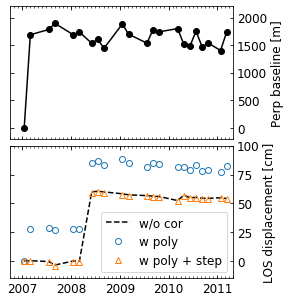

In [53]:
## Fig. S5c-d - Real data on Cerro Azul with ALOS-1

# read data from ALOS dataset
proj_dir = os.path.expanduser('~/insarlab/Galapagos/SierraNegraAlosAT133/mintpy/DEM_ERR')
ts_files = [os.path.join(proj_dir, fname) for fname in ['timeseries_ECMWF_ramp.h5',
                                                        'timeseries_ECMWF_ramp_demErrOrig.h5',
                                                        'timeseries_ECMWF_ramp_demErrExt.h5']]
geom_file = os.path.join(proj_dir, '../inputs/geometryGeo.h5')
# aux info
ts_obj = timeseries(ts_files[0])
ts_obj.open()
dates = np.array(ts_obj.times)
pbase = ts_obj.pbase
pbase -= pbase[0]
# point of interest
coord = ut.coordinate(ts_obj.metadata, lookup_file=geom_file)
lat = -0.928
lon = -91.270
y, x = coord.geo2radar(lat, lon)[0:2]
box = (x, y, x+1, y+1)
# read ts data
ds = []
for ts_file in ts_files:
    dis = readfile.read(ts_file, box=box)[0]
    dis -= dis[0]
    ds.append(dis)

# plot
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=[4, 5], sharex=True)
ax1.plot(dates, pbase,'-ok')
for ts_file, label in zip(ts_files, ['w/o cor', 'w poly', 'w poly + step']):
    dis = readfile.read(ts_file, box=box)[0] * unit_fac
    dis -= dis[0]
ax2.plot(dates, unit_fac * ds[0], 'k--', label='w/o cor')
ax2.plot(dates, unit_fac * ds[1], 'o', ms=6, markerfacecolor='None', label='w poly')
ax2.plot(dates, unit_fac * ds[2], '^', ms=6, markerfacecolor='None', label='w poly + step')
# axis format
ax1.set_ylim(-200, 2200)
ax2.set_ylim(-15, 100)
for ax in [ax1, ax2]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    pp.auto_adjust_xaxis_date(ax, dates)
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax1.set_ylabel('Perp baseline [m]', fontsize=font_size)
ax2.set_ylabel('LOS displacement [cm]', fontsize=font_size)
fig.subplots_adjust(hspace=0.05)
plt.legend(loc='lower right', fontsize=font_size)

#output
out_file = os.path.join(os.getcwd(), 'step4demErr_AlosACerroAzul.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()